In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [52]:
#Define the number of elements in each set I, J, K
i_num = 27
k_num = 5
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [53]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 25000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 25000), 0)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 25000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 25000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 25000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 25000), 0)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,12096.0,2831.0
j1,j1,19589.0,9136.0
j2,j2,17233.0,15056.0
j3,j3,15898.0,14492.0
j4,j4,9836.0,2669.0
...,...,...,...
i22,i22,6721.0,12135.0
i23,i23,22449.0,13115.0
i24,i24,9170.0,16481.0


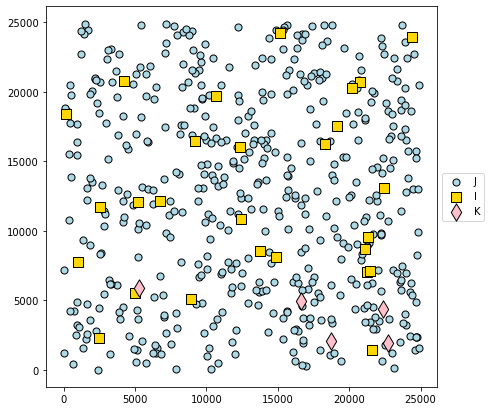

In [54]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [55]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib

# # Doctor's coordinates
# doctors = {'Latitude' : [48.56500199216254, 48.5705, 48.575], 'Longitude' : [13.433214775837387, 13.436, 13.44]}
# df = pd.DataFrame(doctors)
# df

# # create geodataframe, NB CRS
# geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4386")


# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Now file_contents contains the contents of the file as a string
# passau_poly = shapely.wkt.loads(polygon_str)


# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
# folium.GeoJson(passau_gdf).add_to(passau_map)

# geo_doctors = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(icon='circle', prefix='fa', color='blue'), 
#                   icon_size=(0.5, 0.5)).add_to(passau_map)

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



# passau_map

In [56]:
#Define constants

B = 17 * (90 * 60) #battery load: seconds of travel
S = 17 * (10 * 60) #meters of service time
alpha = 14760 + 500 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400000
    else:
        beta[j] = 300000
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

softlimit = 200
hardlimit = 10000

Deterministic model

In [57]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 12,
 'i1': 9,
 'i2': 4,
 'i3': 9,
 'i4': 7,
 'i5': 7,
 'i6': 7,
 'i7': 8,
 'i8': 7,
 'i9': 5,
 'i10': 3,
 'i11': 5,
 'i12': 7,
 'i13': 1,
 'i14': 6,
 'i15': 10,
 'i16': 6,
 'i17': 3,
 'i18': 1,
 'i19': 1,
 'i20': 6,
 'i21': 5,
 'i22': 4,
 'i23': 4,
 'i24': 11,
 'i25': 7,
 'i26': 4}

In [58]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 10657.814644663324,
 ('k0', 'j1'): 7830.346416347108,
 ('k0', 'j2'): 14200.099612326669,
 ('k0', 'j3'): 14269.322198338645,
 ('k0', 'j4'): 12901.606295341677,
 ('k0', 'j5'): 17423.671254933615,
 ('k0', 'j6'): 23930.75314318377,
 ('k0', 'j7'): 8716.006941254693,
 ('k0', 'j8'): 11546.5823948041,
 ('k0', 'j9'): 7988.780758038112,
 ('k0', 'j10'): 21838.193171597326,
 ('k0', 'j11'): 23397.93796470108,
 ('k0', 'j12'): 23014.09014060734,
 ('k0', 'j13'): 30801.11484995308,
 ('k0', 'j14'): 829.6872904896157,
 ('k0', 'j15'): 20492.97684573913,
 ('k0', 'j16'): 7759.0732694053095,
 ('k0', 'j17'): 6222.530032068949,
 ('k0', 'j18'): 14579.032066635975,
 ('k0', 'j19'): 9080.292946816198,
 ('k0', 'j20'): 11381.46269158758,
 ('k0', 'j21'): 15014.586274686359,
 ('k0', 'j22'): 14504.683726300274,
 ('k0', 'j23'): 16128.458853839693,
 ('k0', 'j24'): 18676.090061894647,
 ('k0', 'j25'): 17239.307700716985,
 ('k0', 'j26'): 7659.4279812529085,
 ('k0', 'j27'): 24040.17990781267,
 ('k0', 'j28'): 3

In [59]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [60]:
#Define set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= 0.5*B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i0', 'k1'),
 ('i0', 'k2'),
 ('i0', 'k3'),
 ('i0', 'k4'),
 ('i1', 'k0'),
 ('i1', 'k1'),
 ('i1', 'k2'),
 ('i1', 'k3'),
 ('i1', 'k4'),
 ('i2', 'k0'),
 ('i2', 'k1'),
 ('i2', 'k2'),
 ('i2', 'k3'),
 ('i2', 'k4'),
 ('i3', 'k0'),
 ('i3', 'k1'),
 ('i3', 'k2'),
 ('i3', 'k3'),
 ('i3', 'k4'),
 ('i4', 'k0'),
 ('i4', 'k1'),
 ('i4', 'k2'),
 ('i4', 'k3'),
 ('i4', 'k4'),
 ('i5', 'k0'),
 ('i5', 'k1'),
 ('i5', 'k2'),
 ('i5', 'k3'),
 ('i5', 'k4'),
 ('i6', 'k0'),
 ('i6', 'k1'),
 ('i6', 'k2'),
 ('i6', 'k3'),
 ('i6', 'k4'),
 ('i7', 'k0'),
 ('i7', 'k1'),
 ('i7', 'k2'),
 ('i7', 'k3'),
 ('i7', 'k4'),
 ('i8', 'k0'),
 ('i8', 'k1'),
 ('i8', 'k2'),
 ('i8', 'k3'),
 ('i8', 'k4'),
 ('i9', 'k0'),
 ('i9', 'k1'),
 ('i9', 'k2'),
 ('i9', 'k3'),
 ('i9', 'k4'),
 ('i10', 'k0'),
 ('i10', 'k1'),
 ('i10', 'k2'),
 ('i10', 'k3'),
 ('i10', 'k4'),
 ('i11', 'k0'),
 ('i11', 'k1'),
 ('i11', 'k2'),
 ('i11', 'k3'),
 ('i11', 'k4'),
 ('i12', 'k0'),
 ('i12', 'k1'),
 ('i12', 'k2'),
 ('i12', 'k3'),
 ('i12', 'k4'),
 ('i13', '

In [61]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [62]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i

{'i0': [('k0', 'j1'),
  ('k0', 'j2'),
  ('k0', 'j3'),
  ('k0', 'j7'),
  ('k0', 'j8'),
  ('k0', 'j9'),
  ('k0', 'j14'),
  ('k0', 'j16'),
  ('k0', 'j17'),
  ('k0', 'j18'),
  ('k0', 'j19'),
  ('k0', 'j20'),
  ('k0', 'j22'),
  ('k0', 'j23'),
  ('k0', 'j26'),
  ('k0', 'j28'),
  ('k0', 'j33'),
  ('k0', 'j34'),
  ('k0', 'j36'),
  ('k0', 'j39'),
  ('k0', 'j48'),
  ('k0', 'j52'),
  ('k0', 'j55'),
  ('k0', 'j58'),
  ('k0', 'j60'),
  ('k0', 'j63'),
  ('k0', 'j64'),
  ('k0', 'j65'),
  ('k0', 'j66'),
  ('k0', 'j67'),
  ('k0', 'j75'),
  ('k0', 'j79'),
  ('k0', 'j81'),
  ('k0', 'j82'),
  ('k0', 'j83'),
  ('k0', 'j84'),
  ('k0', 'j85'),
  ('k0', 'j86'),
  ('k0', 'j87'),
  ('k0', 'j88'),
  ('k0', 'j89'),
  ('k0', 'j94'),
  ('k0', 'j97'),
  ('k0', 'j99'),
  ('k0', 'j100'),
  ('k0', 'j104'),
  ('k0', 'j112'),
  ('k0', 'j117'),
  ('k0', 'j118'),
  ('k0', 'j124'),
  ('k0', 'j125'),
  ('k0', 'j127'),
  ('k0', 'j131'),
  ('k0', 'j135'),
  ('k0', 'j138'),
  ('k0', 'j139'),
  ('k0', 'j142'),
  ('k0', 'j145'),


In [63]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

In [64]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [65]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [66]:
model_det.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
model_det.setParam('TimeLimit', hardlimit)
model_det.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 144199 rows, 72352 columns and 196762 nonzeros
Model fingerprint: 0xd9ff48fc
Variable types: 0 continuous, 72352 integer (532 binary)
Coefficient statistics:
  Matrix range     [7e-01, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.292636e+07
Presolve removed 143640 rows and 66561 columns
Presolve time: 0.09s
Presolved: 559 rows, 5791 columns, 11050 nonzeros
Found heuristic solution: objective 8926354.2171
Variable types: 0 continuous, 5791 integer (930 binary)
Found heuristic solution: objective 8926353.9983

Root relaxation: objective 3.380353e+06, 2421 iterations, 0.03 seconds (0.02 work units)



In [67]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 7
0
3.62635e+06 
x_ikj[i0,k4,k4] 12
x_ikj[i1,k3,k3] 9
x_ikj[i2,k3,k3] 4
x_ikj[i3,k1,i3] 9
x_ikj[i4,k4,k4] 7
x_ikj[i5,k1,i3] 7
x_ikj[i6,k3,k3] 7
x_ikj[i7,k1,i3] 8
x_ikj[i8,k3,i22] 7
x_ikj[i9,k3,i22] 5
x_ikj[i10,k3,i22] 3
x_ikj[i11,k4,k4] 5
x_ikj[i12,k1,i3] 7
x_ikj[i13,k1,i3] 1
x_ikj[i14,k1,i3] 6
x_ikj[i15,k3,k3] 10
x_ikj[i16,k3,i22] 6
x_ikj[i17,k3,k3] 3
x_ikj[i18,k3,k3] 1
x_ikj[i19,k3,k3] 1
x_ikj[i20,k4,k4] 6
x_ikj[i21,k4,k4] 5
x_ikj[i22,k3,k3] 4
x_ikj[i23,k4,k4] 4
x_ikj[i24,k3,i22] 11
x_ikj[i25,k3,k3] 7
x_ikj[i26,k4,k4] 4
y_j[k3] 1
y_j[k4] 1
y_j[i3] 1
y_j[i22] 1


1
3.62635e+06 
x_ikj[i0,k4,k4] 12
x_ikj[i1,k3,k3] 9
x_ikj[i2,k3,k3] 4
x_ikj[i3,k1,i3] 9
x_ikj[i4,k4,k4] 7
x_ikj[i5,k1,i3] 7
x_ikj[i6,k3,k3] 7
x_ikj[i7,k1,i3] 8
x_ikj[i8,k3,i22] 7
x_ikj[i9,k3,i22] 5
x_ikj[i10,k3,i22] 3
x_ikj[i11,k4,k4] 5
x_ikj[i12,k1,i3] 7
x_ikj[i13,k1,i3] 1
x_ikj[i14,k1,i3] 6
x_ikj[i15,k3,k3] 10
x_ikj[i16,k3,i22] 6
x_ikj[i17,k3,k3] 3
x_ikj[i18,k3,k3] 1
x_ikj[i19,k3,k3] 1
x_ikj[i20,k

In [68]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations, results_labs

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                12
 1    i1                 9
 2   i10                 3
 3   i11                 5
 4   i12                 7
 5   i13                 1
 6   i14                 6
 7   i15                10
 8   i16                 6
 9   i17                 3
 10  i18                 1
 11  i19                 1
 12   i2                 4
 13  i20                 6
 14  i21                 5
 15  i22                 4
 16  i23                 4
 17  i24                11
 18  i25                 7
 19  i26                 4
 20   i3                 9
 21   i4                 7
 22   i5                 7
 23   i6                 7
 24   i7                 8
 25   i8                 7
 26   i9                 5,
      j  Number of drones
 0  i22                32
 1   i3                38
 2   k3                46
 3   k4                43,
     k  Number of drones
 0  k1                38
 1  k3                78
 2  k4                43)

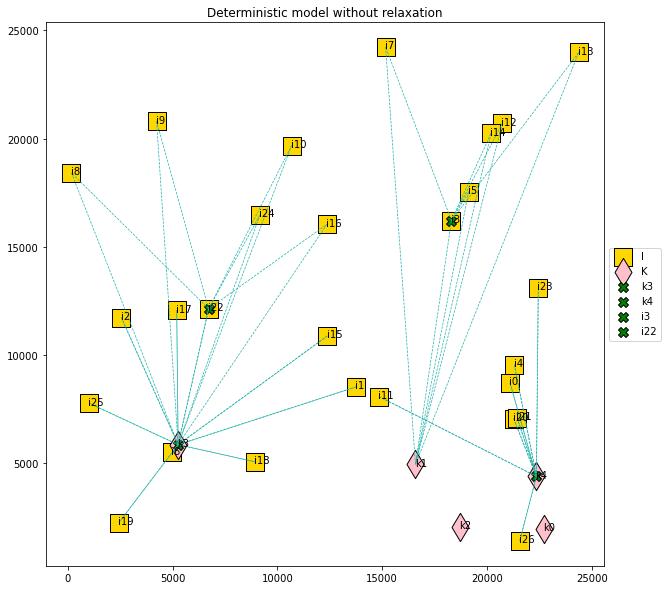

In [69]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (10, 10))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Latitude'][i] - 40, I['Longitude'][i] - 60))
                
        fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Latitude'][k] - 40, K['Longitude'][k] - 60))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                #(K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                # fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                #                                 (J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

Probabilistic model

In [70]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 5

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [71]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [72]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [73]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [74]:
model_prob.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

In [75]:
model_prob.setParam('TimeLimit', hardlimit)
model_prob.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 145053 rows, 73232 columns and 1833093 nonzeros
Model fingerprint: 0xc986287a
Variable types: 0 continuous, 73232 integer (1412 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.553585e+07
Presolve removed 144494 rows and 67440 columns
Presolve time: 0.94s
Presolved: 559 rows, 5792 columns, 11077 nonzeros
Found heuristic solution: objective 1.193583e+07
Variable types: 0 continuous, 5792 integer (532 binary)
Found heuristic solution: obje

In [76]:
ListSolution(model_prob)

Number of solutions found: 6
0
7.13583e+06 
x_ikj[i0,k4,i0] 16
x_ikj[i1,k1,i11] 18
x_ikj[i2,k3,i2] 10
x_ikj[i3,k1,i3] 6
x_ikj[i3,k1,i11] 2
x_ikj[i3,k4,i0] 8
x_ikj[i4,k4,k4] 4
x_ikj[i4,k4,i0] 12
x_ikj[i5,k4,i0] 14
x_ikj[i6,k3,k3] 9
x_ikj[i7,k1,i3] 10
x_ikj[i8,k3,i2] 16
x_ikj[i9,k3,i2] 4
x_ikj[i9,k3,i22] 5
x_ikj[i10,k3,i22] 7
x_ikj[i11,k1,i11] 12
x_ikj[i12,k1,i3] 13
x_ikj[i13,k1,i3] 9
x_ikj[i14,k1,i3] 12
x_ikj[i15,k1,i11] 17
x_ikj[i16,k1,i11] 1
x_ikj[i16,k3,i22] 15
x_ikj[i17,k3,k3] 9
x_ikj[i18,k3,k3] 5
x_ikj[i19,k3,k3] 5
x_ikj[i20,k4,k4] 13
x_ikj[i21,k4,k4] 7
x_ikj[i22,k3,k3] 4
x_ikj[i22,k3,i22] 9
x_ikj[i23,k4,k4] 10
x_ikj[i24,k3,i22] 14
x_ikj[i25,k3,k3] 18
x_ikj[i26,k4,k4] 16
y_j[k3] 1
y_j[k4] 1
y_j[i0] 1
y_j[i2] 1
y_j[i3] 1
y_j[i11] 1
y_j[i22] 1


1
7.23583e+06 
x_ikj[i0,k4,i0] 16
x_ikj[i1,k1,i11] 18
x_ikj[i2,k3,i2] 10
x_ikj[i3,k1,i3] 6
x_ikj[i3,k1,i11] 2
x_ikj[i3,k4,i0] 8
x_ikj[i4,k4,k4] 4
x_ikj[i4,k4,i0] 12
x_ikj[i5,k4,i0] 14
x_ikj[i6,k3,k3] 9
x_ikj[i7,k1,i3] 10
x_ikj[i8,k3,i2] 16
x_

In [77]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                16
 1    i1                18
 2   i10                 7
 3   i11                12
 4   i12                13
 5   i13                 9
 6   i14                12
 7   i15                17
 8   i16                16
 9   i17                 9
 10  i18                 5
 11  i19                 5
 12   i2                10
 13  i20                13
 14  i21                 7
 15  i22                13
 16  i23                10
 17  i24                14
 18  i25                18
 19  i26                16
 20   i3                16
 21   i4                16
 22   i5                14
 23   i6                 9
 24   i7                10
 25   i8                16
 26   i9                 9,
      j  Number of drones
 0   i0                50
 1  i11                50
 2   i2                30
 3  i22                50
 4   i3                50
 5   k3                50
 6   k4                50,
     k  Number of drones
 0  k1   

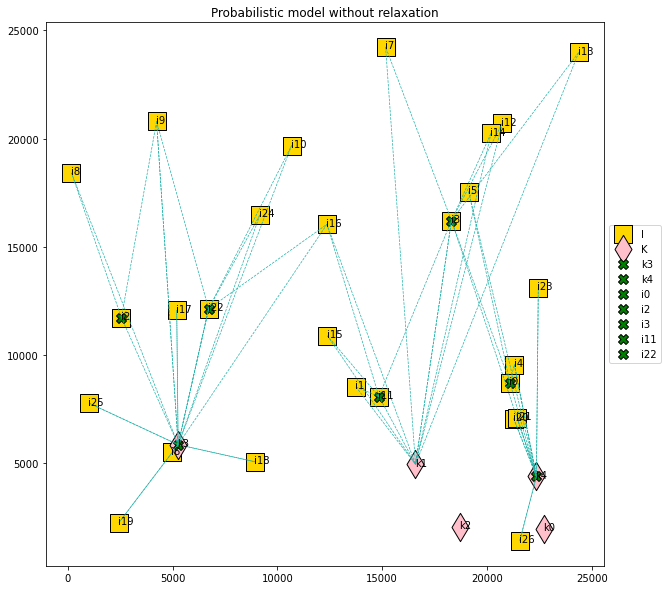

In [79]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [83]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [85]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i0', 'k1'),
 ('i0', 'k2'),
 ('i0', 'k3'),
 ('i0', 'k4'),
 ('i1', 'k0'),
 ('i1', 'k1'),
 ('i1', 'k2'),
 ('i1', 'k3'),
 ('i1', 'k4'),
 ('i2', 'k0'),
 ('i2', 'k1'),
 ('i2', 'k2'),
 ('i2', 'k3'),
 ('i2', 'k4'),
 ('i3', 'k0'),
 ('i3', 'k1'),
 ('i3', 'k2'),
 ('i3', 'k3'),
 ('i3', 'k4'),
 ('i4', 'k0'),
 ('i4', 'k1'),
 ('i4', 'k2'),
 ('i4', 'k3'),
 ('i4', 'k4'),
 ('i5', 'k0'),
 ('i5', 'k1'),
 ('i5', 'k2'),
 ('i5', 'k3'),
 ('i5', 'k4'),
 ('i6', 'k0'),
 ('i6', 'k1'),
 ('i6', 'k2'),
 ('i6', 'k3'),
 ('i6', 'k4'),
 ('i7', 'k0'),
 ('i7', 'k1'),
 ('i7', 'k2'),
 ('i7', 'k3'),
 ('i7', 'k4'),
 ('i8', 'k0'),
 ('i8', 'k1'),
 ('i8', 'k2'),
 ('i8', 'k3'),
 ('i8', 'k4'),
 ('i9', 'k0'),
 ('i9', 'k1'),
 ('i9', 'k2'),
 ('i9', 'k3'),
 ('i9', 'k4'),
 ('i10', 'k0'),
 ('i10', 'k1'),
 ('i10', 'k2'),
 ('i10', 'k3'),
 ('i10', 'k4'),
 ('i11', 'k0'),
 ('i11', 'k1'),
 ('i11', 'k2'),
 ('i11', 'k3'),
 ('i11', 'k4'),
 ('i12', 'k0'),
 ('i12', 'k1'),
 ('i12', 'k2'),
 ('i12', 'k3'),
 ('i12', 'k4'),
 ('i13', '

In [86]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [88]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [89]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

In [91]:
# #Redefine constants and random variables


# I_feasG = []
# for i in I_feas:
#     for g in range(1, g_i[i] + 1):
#         I_feasG.append((i, g))

In [93]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [95]:

model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [97]:
model_prob_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_prob_rel.setParam('TimeLimit', hardlimit)
model_prob_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 145054 rows, 73232 columns and 1833619 nonzeros
Model fingerprint: 0x5b595466
Variable types: 0 continuous, 73232 integer (1412 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.553585e+07
Presolve removed 144495 rows and 67440 columns
Presolve time: 0.81s
Presolved: 559 rows, 5792 columns, 11077 nonzeros
Found heuristic solution: objective 1.193583e+07
Variable types: 0 continuous, 5792 integer (532 binary)
Found heuristic solution: obje

In [98]:
ListSolution(model_prob_rel)

Number of solutions found: 6
0
7.13583e+06 
x_ikj[i0,k4,i0] 16
x_ikj[i1,k1,i11] 18
x_ikj[i2,k3,i2] 10
x_ikj[i3,k1,i3] 6
x_ikj[i3,k1,i11] 2
x_ikj[i3,k4,i0] 8
x_ikj[i4,k4,k4] 4
x_ikj[i4,k4,i0] 12
x_ikj[i5,k4,i0] 14
x_ikj[i6,k3,k3] 9
x_ikj[i7,k1,i3] 10
x_ikj[i8,k3,i2] 16
x_ikj[i9,k3,i2] 4
x_ikj[i9,k3,i22] 5
x_ikj[i10,k3,i22] 7
x_ikj[i11,k1,i11] 12
x_ikj[i12,k1,i3] 13
x_ikj[i13,k1,i3] 9
x_ikj[i14,k1,i3] 12
x_ikj[i15,k1,i11] 17
x_ikj[i16,k1,i11] 1
x_ikj[i16,k3,i22] 15
x_ikj[i17,k3,k3] 9
x_ikj[i18,k3,k3] 5
x_ikj[i19,k3,k3] 5
x_ikj[i20,k4,k4] 13
x_ikj[i21,k4,k4] 7
x_ikj[i22,k3,k3] 4
x_ikj[i22,k3,i22] 9
x_ikj[i23,k4,k4] 10
x_ikj[i24,k3,i22] 14
x_ikj[i25,k3,k3] 18
x_ikj[i26,k4,k4] 16
y_j[k3] 1
y_j[k4] 1
y_j[i0] 1
y_j[i2] 1
y_j[i3] 1
y_j[i11] 1
y_j[i22] 1


1
7.23583e+06 
x_ikj[i0,k4,i0] 16
x_ikj[i1,k1,i11] 18
x_ikj[i2,k3,i2] 10
x_ikj[i3,k1,i3] 6
x_ikj[i3,k1,i11] 2
x_ikj[i3,k4,i0] 8
x_ikj[i4,k4,k4] 4
x_ikj[i4,k4,i0] 12
x_ikj[i5,k4,i0] 14
x_ikj[i6,k3,k3] 9
x_ikj[i7,k1,i3] 10
x_ikj[i8,k3,i2] 16
x_

In [99]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                16
 1    i1                18
 2   i10                 7
 3   i11                12
 4   i12                13
 5   i13                 9
 6   i14                12
 7   i15                17
 8   i16                16
 9   i17                 9
 10  i18                 5
 11  i19                 5
 12   i2                10
 13  i20                13
 14  i21                 7
 15  i22                13
 16  i23                10
 17  i24                14
 18  i25                18
 19  i26                16
 20   i3                16
 21   i4                16
 22   i5                14
 23   i6                 9
 24   i7                10
 25   i8                16
 26   i9                 9,
      j  Number of drones
 0   i0                50
 1  i11                50
 2   i2                30
 3  i22                50
 4   i3                50
 5   k3                50
 6   k4                50,
     k  Number of drones
 0  k1   

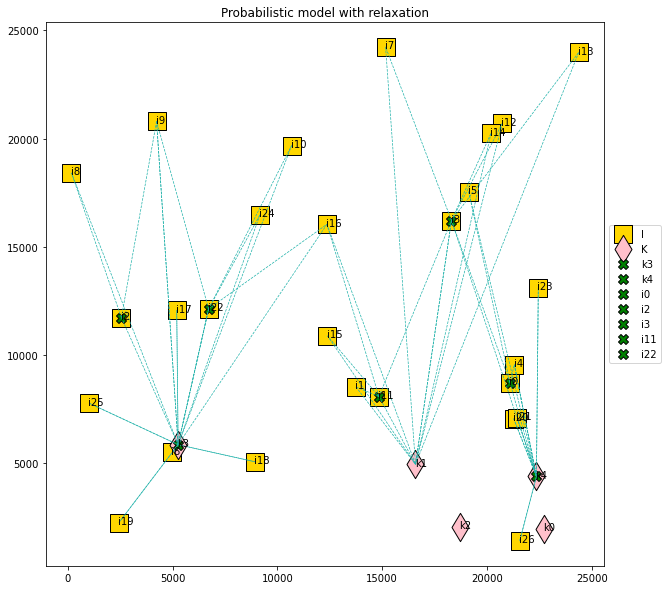

In [100]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [103]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [104]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')

model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [106]:
model_det_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_det_rel.setParam('TimeLimit', hardlimit)
model_det_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 144199 rows, 72352 columns and 196762 nonzeros
Model fingerprint: 0xf01e4d47
Variable types: 0 continuous, 72352 integer (532 binary)
Coefficient statistics:
  Matrix range     [7e-01, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.292636e+07
Presolve removed 143640 rows and 66561 columns
Presolve time: 0.11s
Presolved: 559 rows, 5791 columns, 11050 nonzeros
Found heuristic solution: objective 8926354.2171
Variable types: 0 continuous, 5791 integer (930 binary)
Found heuristic solution: objective 8926353.9983

Root relaxation: objective 3.380353e+06, 2421 iterations, 0.02 seconds (0.02 work units)



In [107]:
ListSolution(model_det_rel)

Number of solutions found: 7
0
3.62635e+06 
x_ikj[i0,k4,k4] 12
x_ikj[i1,k3,k3] 9
x_ikj[i2,k3,k3] 4
x_ikj[i3,k1,i3] 9
x_ikj[i4,k4,k4] 7
x_ikj[i5,k1,i3] 7
x_ikj[i6,k3,k3] 7
x_ikj[i7,k1,i3] 8
x_ikj[i8,k3,i22] 7
x_ikj[i9,k3,i22] 5
x_ikj[i10,k3,i22] 3
x_ikj[i11,k4,k4] 5
x_ikj[i12,k1,i3] 7
x_ikj[i13,k1,i3] 1
x_ikj[i14,k1,i3] 6
x_ikj[i15,k3,k3] 10
x_ikj[i16,k3,i22] 6
x_ikj[i17,k3,k3] 3
x_ikj[i18,k3,k3] 1
x_ikj[i19,k3,k3] 1
x_ikj[i20,k4,k4] 6
x_ikj[i21,k4,k4] 5
x_ikj[i22,k3,k3] 4
x_ikj[i23,k4,k4] 4
x_ikj[i24,k3,i22] 11
x_ikj[i25,k3,k3] 7
x_ikj[i26,k4,k4] 4
y_j[k3] 1
y_j[k4] 1
y_j[i3] 1
y_j[i22] 1


1
3.62635e+06 
x_ikj[i0,k4,k4] 12
x_ikj[i1,k3,k3] 9
x_ikj[i2,k3,k3] 4
x_ikj[i3,k1,i3] 9
x_ikj[i4,k4,k4] 7
x_ikj[i5,k1,i3] 7
x_ikj[i6,k3,k3] 7
x_ikj[i7,k1,i3] 8
x_ikj[i8,k3,i22] 7
x_ikj[i9,k3,i22] 5
x_ikj[i10,k3,i22] 3
x_ikj[i11,k4,k4] 5
x_ikj[i12,k1,i3] 7
x_ikj[i13,k1,i3] 1
x_ikj[i14,k1,i3] 6
x_ikj[i15,k3,k3] 10
x_ikj[i16,k3,i22] 6
x_ikj[i17,k3,k3] 3
x_ikj[i18,k3,k3] 1
x_ikj[i19,k3,k3] 1
x_ikj[i20,k

In [108]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                12
 1    i1                 9
 2   i10                 3
 3   i11                 5
 4   i12                 7
 5   i13                 1
 6   i14                 6
 7   i15                10
 8   i16                 6
 9   i17                 3
 10  i18                 1
 11  i19                 1
 12   i2                 4
 13  i20                 6
 14  i21                 5
 15  i22                 4
 16  i23                 4
 17  i24                11
 18  i25                 7
 19  i26                 4
 20   i3                 9
 21   i4                 7
 22   i5                 7
 23   i6                 7
 24   i7                 8
 25   i8                 7
 26   i9                 5,
      j  Number of drones
 0  i22                32
 1   i3                38
 2   k3                46
 3   k4                43,
     k  Number of drones
 0  k1                38
 1  k3                78
 2  k4                43)

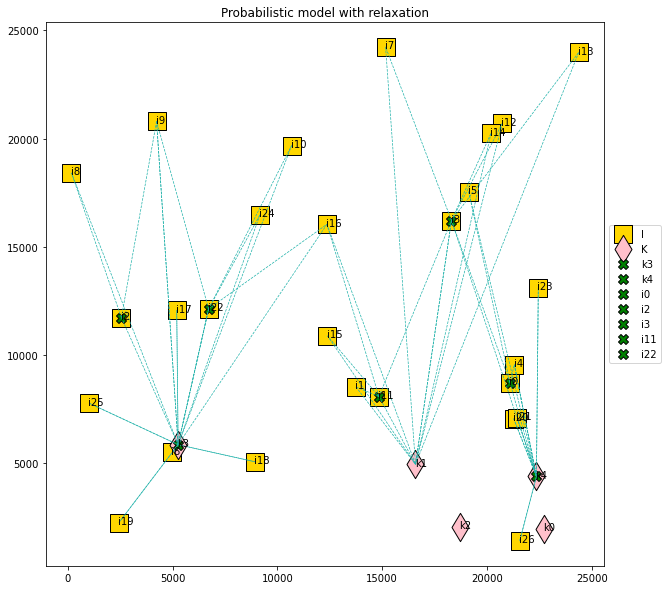

In [109]:
SolutionGraph(I, K, J, model_prob_rel)

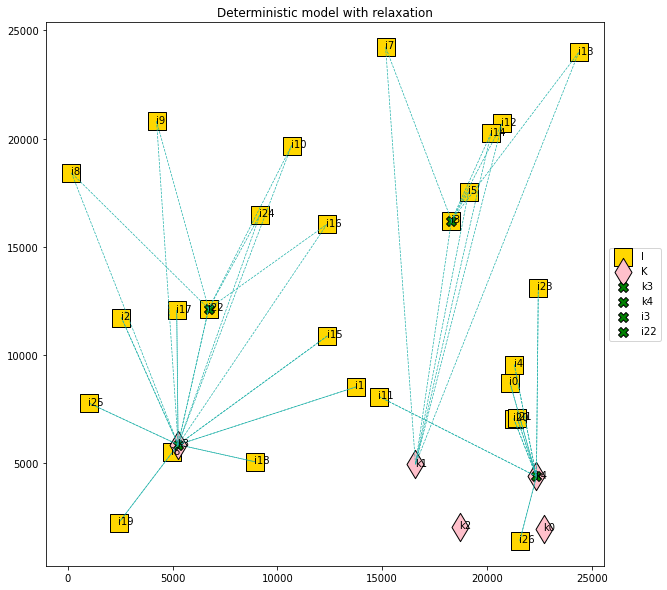

In [110]:
SolutionGraph(I, K, J, model_det_rel)

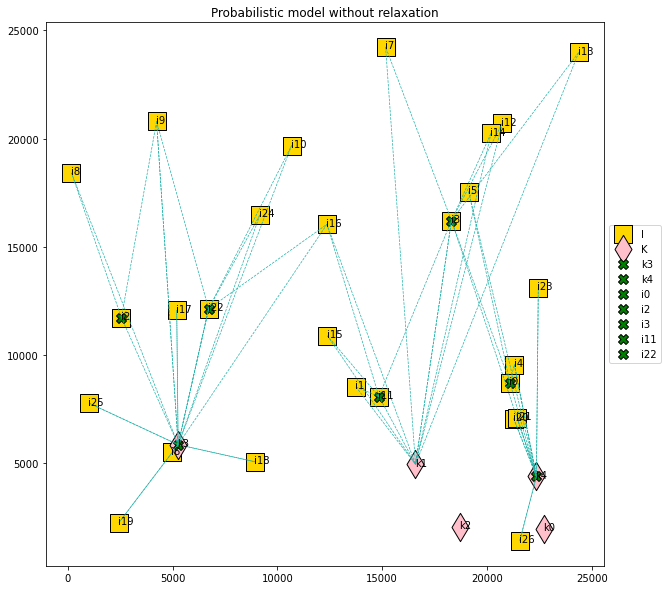

In [111]:
SolutionGraph(I, K, J, model_prob)

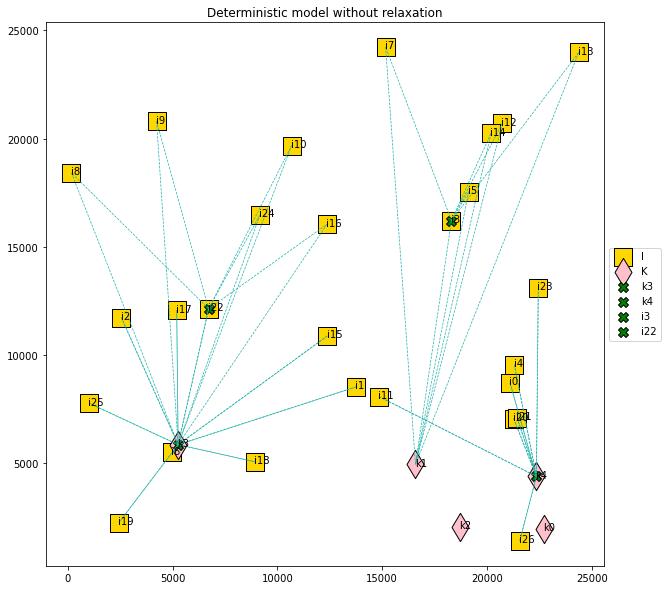

In [112]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty